# Linear-Gaussian Model

Code from *An Introduction to Bayesian Filtering: Theory and Methods* by Dr Ö. Deniz Akyildiz:
 - https://akyildiz.me/ssbf-2024-intro/Particle-Filtering/particle-filter-linear.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define the model parameters
kappa = 0.04

# A will be 4x4 dimensional matrix, the upper left block is identity 
# of size 2x2 and the lower right block is 0.99 * identity of size 2x2, 
# the upper right block is kappa * identity of size 2x2 and the lower 
# left block is 0
A = np.array([[1, 0, kappa, 0], [0, 1, 0, kappa], [0, 0, 0.99, 0], [0, 0, 0, 0.99]])
A

array([[1.  , 0.  , 0.04, 0.  ],
       [0.  , 1.  , 0.  , 0.04],
       [0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.  , 0.  , 0.99]])

In [3]:
Q = np.array([[kappa**3/3, 0, kappa**2/2, 0], [0, kappa**3/3, 0, kappa**2/2], [kappa**2/2, 0, kappa, 0], [0, kappa**2/2, 0, kappa]])
Q

array([[2.13333333e-05, 0.00000000e+00, 8.00000000e-04, 0.00000000e+00],
       [0.00000000e+00, 2.13333333e-05, 0.00000000e+00, 8.00000000e-04],
       [8.00000000e-04, 0.00000000e+00, 4.00000000e-02, 0.00000000e+00],
       [0.00000000e+00, 8.00000000e-04, 0.00000000e+00, 4.00000000e-02]])

In [4]:
# Number of timesteps
T = 400

In [5]:
# Define the initial state
x = np.zeros((4, T))
y = np.zeros((2, T))
x[:, 0] = np.array([0, 0, -10, -10])

In [6]:
# Measurement matrix
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
sig_y = 5
R = sig_y * np.eye(2)
R

array([[5., 0.],
       [0., 5.]])

In [7]:
# Simulate system
y[:, 0] = H @ x[:, 0] + np.random.multivariate_normal(np.zeros(2), R)
for t in range(1, T):
    x[:, t] = A.dot(x[:, t-1]) + np.random.multivariate_normal(np.zeros(4), Q)
    y[:, t] = H.dot(x[:, t]) + np.random.multivariate_normal(np.zeros(2), R)


In [8]:
# Initialize particle filter
N = 1000
x_particles = np.zeros((4, N))
x_particles[:, :] = np.random.multivariate_normal(x[:, 0], 1 * np.eye(4), N).T
x_particles_pred = np.zeros((4, N))

In [9]:
x_est = np.zeros((4, T))
log_w = np.zeros(N)
x_particles = np.random.multivariate_normal(x[:, 0], 0.1 * np.eye(4), N).T
for t in tqdm(range(1, T)):

    # Prediction step
    x_particles_pred = A @ x_particles + np.random.multivariate_normal(np.zeros(4), Q, N).T

    # Update step
    for i in range(N):
        log_w[i] = log_w[i] - (0.5 * (y[:, t] - H @ x_particles_pred[:, i]).T @ np.linalg.inv(R) @ (y[:, t] - H @ x_particles_pred[:, i]))

    W = np.exp(log_w - np.max(log_w))

    w = W / np.sum(W)

    x_est[:, t] = np.sum(w * x_particles_pred, axis=1)

    x_particles = x_particles_pred[:, np.random.choice(N, N, p=w)]
    log_w = np.zeros(N)


100%|█████████████████████████████████████████| 399/399 [00:10<00:00, 38.53it/s]


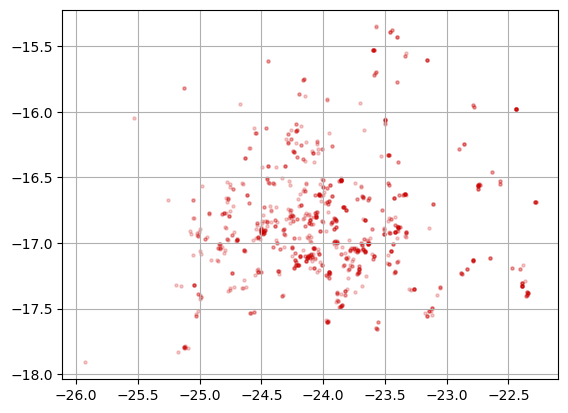

In [10]:
plt.scatter(x_particles[0, :], x_particles[1, :], color = [0.8, 0, 0], alpha=0.2, s=5)
plt.grid()

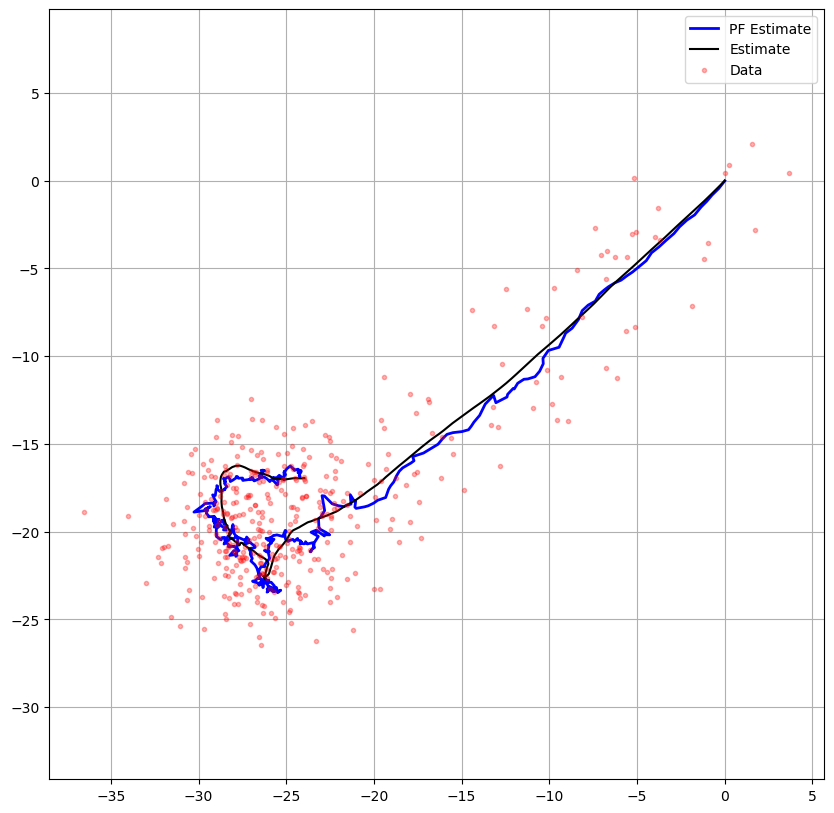

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(x_est[0, :t], x_est[1, :t], 'b-', linewidth=2, label='PF Estimate')
plt.plot(x[0, 0:t+1], x[1, 0:t+1], 'k', label='Estimate')
plt.plot(y[0, 0:t], y[1, 0:t], 'r.', alpha = 0.3, label='Data')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()